# Xarray + Cloud OISST (One-Month) Basics & Stats

This notebook demonstrates basic **xarray** operations on a **one-month** subset of a cloud-hosted climate dataset: **NOAA OISST v2.1 daily SST** on AWS Public Datasets (NetCDF files). You'll:
- Discover files for one month on S3 with `fsspec`
- Open them with `xarray.open_mfdataset` (anonymous S3)
- Inspect dataset structure
- Subset in space (and within that month)
- Compute basic stats (mean, std, anomalies relative to the month’s mean)
- Make maps of the month-mean and variability

**Deliverables:** Answer the **🧩 Questions** in the markdown prompts. Fill in the code where indicated by `# TODO`.


In [1]:
import xarray as xr
import fsspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120


In [2]:
import dask
import distributed
print(dask.__version__)
print(distributed.__version__)

2025.9.1
2025.9.1


In [3]:
import h5netcdf
print(h5netcdf.__version__)

1.6.4


In [4]:
print(xr.backends.list_engines())

{'netcdf4': <NetCDF4BackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html, 'h5netcdf': <H5netcdfBackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html, 'scipy': <ScipyBackendEntrypoint>
  Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html, 'store': <StoreBackendEntrypoint>
  Open AbstractDataStore instances in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html}


## 1) Open the cloud dataset (NetCDF on AWS, one month)

We'll access **NOAA OISST v2.1 (daily)** in the NOAA CDR bucket on AWS. Files are arranged by **YYYYMM**.

**🧩 Questions**
1. What engine are we using to read NetCDF files from S3?

    ANSWER: engine="h5netcdf"

2. Why do we need `storage_options={'anon': True}`?

    ANSWER: We need to use `storage_options={'anon': True}` to make sure we can access the data without authentication issues.

3. Inspect dataset attributes: what are the units and long name of `sst`?

    ANSWER: long name: 'Daily sea surface temperature' units: 'Celsius'


In [7]:
yearmonth = "202001"  # TODO: try other months like "201507" or "201909"
prefix = f"noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/{yearmonth}/oisst-avhrr-v02r01.*.nc"

fs = fsspec.filesystem("s3", anon=True)
paths = sorted(fs.glob(prefix))
print(f"Found {len(paths)} files for {yearmonth}. Example:", paths[:2])

urls = [f"s3://{p}" for p in paths]

ds = xr.open_mfdataset(
    urls,
    engine="h5netcdf",
    combine="by_coords",
    decode_times=True,
    mask_and_scale=True,
    backend_kwargs={"storage_options": {"anon": True}},
    chunks={"time": 1}
)

ds


Found 31 files for 202001. Example: ['noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/202001/oisst-avhrr-v02r01.20200101.nc', 'noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/202001/oisst-avhrr-v02r01.20200102.nc']


<xarray.Dataset> Size: 514MB
Dimensions:  (time: 31, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-01T12:00:00 ... 2020-01-31T12...
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * zlev     (zlev) float32 4B 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    naming_authority:           gov.noaa.ncei
    cdm_data_type:              Grid
    date_modified:              2020-02-11T16:01:00Z
    date_created:               2020-02-11T16:01:00Z
    processing_level:           NOAA Level 4
    ...                         ...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    product_version:            Version v02r01
    platform:                   Ships, buoys, Argo floats, MetOp-A, MetOp-B
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    id:                         oisst-avhrr-v02r01.20200101.nc

## 2) Explore coordinates & variables

**🧩 Questions**
1. What are the coordinate names for time and space?

    ANSWER: time: 'time' space: 'lat' and 'lon'

2. What is the shape of `sst`?

    ANSWER: (31, 1, 720, 1440)

3. How are missing values represented?

    ANSWER: 'NaN'


In [8]:
list(ds.data_vars), list(ds.coords)

(['anom', 'err', 'ice', 'sst'], ['time', 'lat', 'lon', 'zlev'])

In [13]:
ds.coords
ds.sst.shape
ds.sst.isnull().sum()

<xarray.DataArray 'sst' ()> Size: 8B
dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>

In [14]:
ds.sst

<xarray.DataArray 'sst' (time: 31, zlev: 1, lat: 720, lon: 1440)> Size: 129MB
dask.array<concatenate, shape=(31, 1, 720, 1440), dtype=float32, chunksize=(1, 1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-01T12:00:00 ... 2020-01-31T12...
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    valid_min:  -300
    valid_max:  4500
    units:      Celsius

## 3) Time & space subsetting

We'll select a **regional box** (e.g., Gulf of Mexico) within this month.

**🧩 Questions**
1. What lon/lat bounds did you choose?

    ANSWER: I chose the Central Pacific region between 5°S and 5°N and 170°E and 240°E

2. How many daily steps are present in this month?

    ANSWER: There are 31 daily steps in this month


In [ ]:
var = "sst"

lon_min, lon_max = 170, 240
lat_min, lat_max =  -5,  5

def to_0360(lon):
    lon = np.asarray(lon)
    out = np.mod(lon, 360.0)
    out[out < 0] += 360.0
    return out

lon_min_0360, lon_max_0360 = to_0360([lon_min, lon_max])

dss = ds.sel(
    lon=slice(lon_min_0360, lon_max_0360),
    lat=slice(lat_min, lat_max)
)

dss[var]


<xarray.DataArray 'sst' (time: 31, zlev: 1, lat: 40, lon: 280)> Size: 1MB
dask.array<getitem, shape=(31, 1, 40, 280), dtype=float32, chunksize=(1, 1, 40, 280), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-01T12:00:00 ... 2020-01-31T12...
  * lat      (lat) float32 160B -4.875 -4.625 -4.375 ... 4.375 4.625 4.875
  * lon      (lon) float32 1kB 170.1 170.4 170.6 170.9 ... 239.4 239.6 239.9
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    valid_min:  -300
    valid_max:  4500
    units:      Celsius

In [19]:
dss[var].sizes['time']

31

## 4) Basic statistics

Compute region-wide stats through time and over space **within this month**.

**🧩 Questions**
1. Compute the spatial mean SST time series over your box. What is the monthly average and standard deviation?

    ANSWER: 'Month mean SST (°C): 27.803251266479492' & 'Month std SST (°C): 0.10850071161985397'

2. Compute within-month anomalies (subtract the month-mean). What are the largest positive and negative anomalies?

    ANSWER: 'Max anomaly (°C): 0.20082686841487885' & 'Min anomaly (°C): -0.15242847800254822'

3. What day had the warmest/coolest region-mean SST?

    ANSWER: 'Warmest day: 2020-01-01 28.004079818725586' & 'Coolest day: 2020-01-18 27.65082359313965'


Month mean SST (°C): 27.803251266479492
Month std SST (°C): 0.10850071161985397


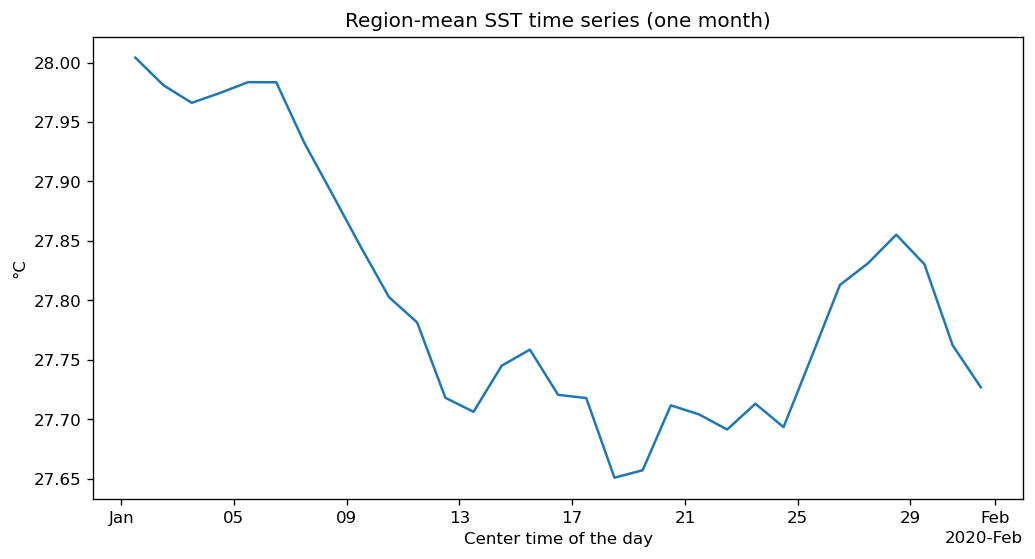

Warmest day: 2020-01-01 28.004079818725586
Coolest day: 2020-01-18 27.65082359313965


/var/folders/wv/kljb_44900987xbshx091lnc0000gn/T/ipykernel_39738/4235597154.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
/var/folders/wv/kljb_44900987xbshx091lnc0000gn/T/ipykernel_39738/4235597154.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


In [20]:
ts = dss[var].mean(dim=['lat','lon'])

ts_mean = ts.mean().compute()
ts_std  = ts.std().compute()
print('Month mean SST (°C):', float(ts_mean.values))
print('Month std SST (°C):', float(ts_std.values))

ts.load().plot()
plt.title('Region-mean SST time series (one month)')
plt.ylabel('°C')
plt.show()

imax = int(ts.argmax('time'))
imin = int(ts.argmin('time'))
print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


Max anomaly (°C): 0.20082686841487885
Min anomaly (°C): -0.15242847800254822


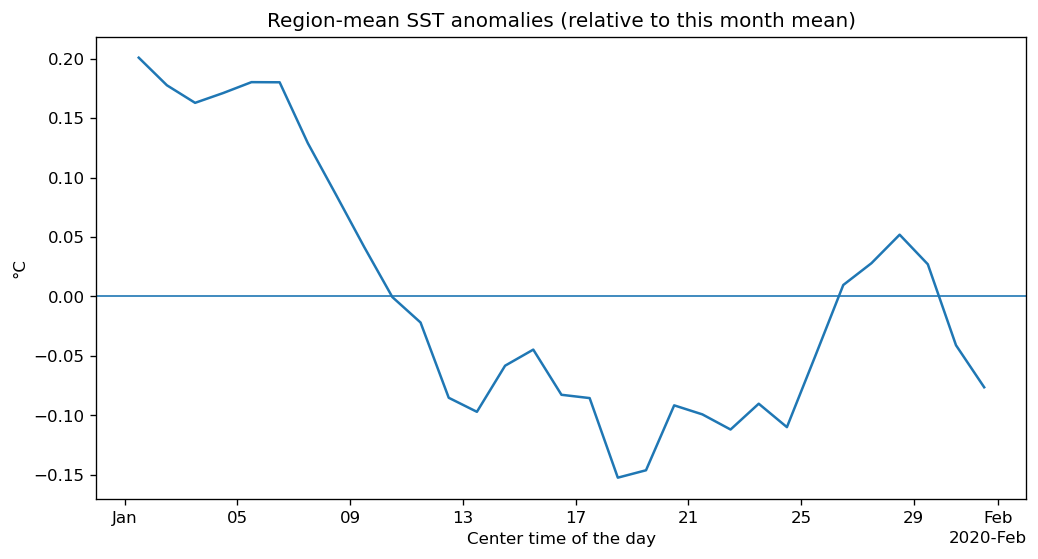

In [21]:
month_mean = dss[var].mean('time')
anom = dss[var] - month_mean

ts_anom = anom.mean(dim=['lat','lon'])
print('Max anomaly (°C):', float(ts_anom.max().compute().values))
print('Min anomaly (°C):', float(ts_anom.min().compute().values))

ts_anom.load().plot()
plt.title('Region-mean SST anomalies (relative to this month mean)')
plt.axhline(0, lw=1)
plt.ylabel('°C')
plt.show()


## 5) Regional maps: month-mean and variability

Make maps of month-mean SST and within-month variability (std and range).

**🧩 Questions**
1. What patterns do you notice?
2. Where is variability strongest?


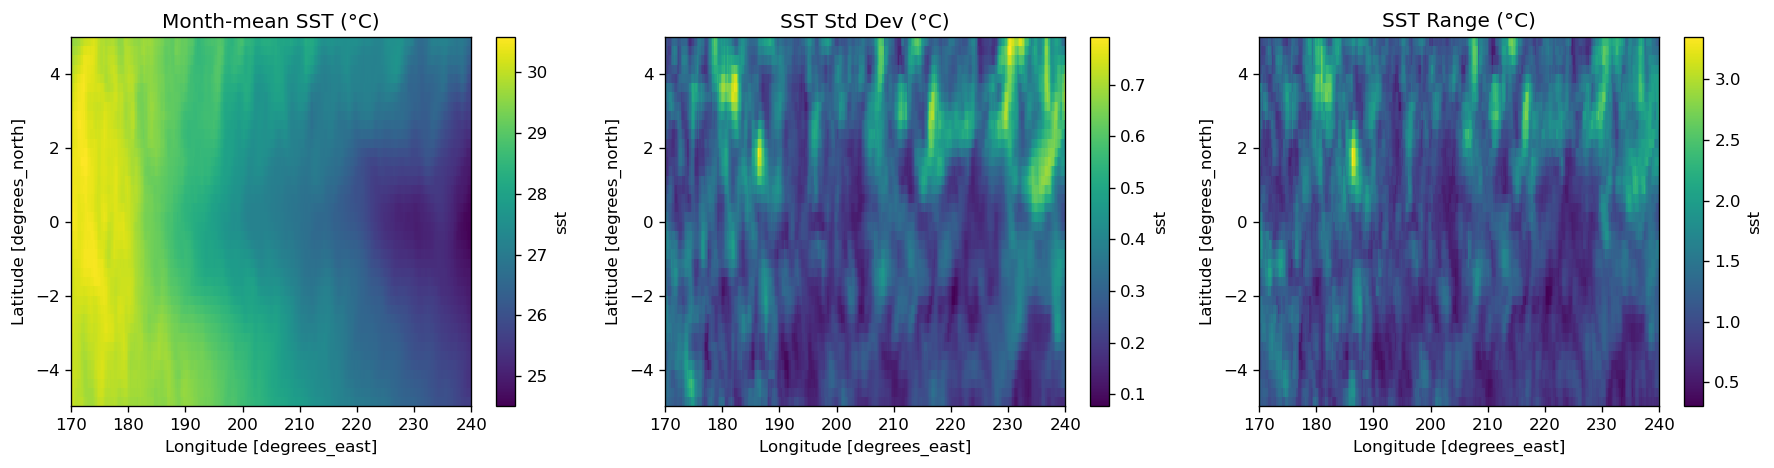

In [22]:
mean_sst = dss[var].mean('time')
std_sst  = dss[var].std('time')
range_sst = dss[var].max('time') - dss[var].min('time')

fig = plt.figure(figsize=(15,4))
ax = plt.subplot(1,3,1); mean_sst.plot(ax=ax); ax.set_title('Month-mean SST (°C)')
ax = plt.subplot(1,3,2); std_sst.plot(ax=ax); ax.set_title('SST Std Dev (°C)')
ax = plt.subplot(1,3,3); range_sst.plot(ax=ax); ax.set_title('SST Range (°C)')
plt.tight_layout(); plt.show()


In [23]:
mean_sst

<xarray.DataArray 'sst' (zlev: 1, lat: 40, lon: 280)> Size: 45kB
dask.array<mean_agg-aggregate, shape=(1, 40, 280), dtype=float32, chunksize=(1, 40, 280), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 160B -4.875 -4.625 -4.375 ... 4.375 4.625 4.875
  * lon      (lon) float32 1kB 170.1 170.4 170.6 170.9 ... 239.4 239.6 239.9
  * zlev     (zlev) float32 4B 0.0

## 6) Export a small subset for sharing (Check In Problem for Module 2)

Write a NetCDF with your regional mean time series and month-mean/variability maps.  Upload with your committed repository.

In [24]:
assignment_ds = xr.Dataset(
    {
        "regional_mean": ts,
        "monthly_mean": mean_sst,
        "monthly_std": std_sst,
        "monthly_variability": range_sst
    }
)

In [25]:
assignment_ds

<xarray.Dataset> Size: 136kB
Dimensions:              (time: 31, zlev: 1, lat: 40, lon: 280)
Coordinates:
  * time                 (time) datetime64[ns] 248B 2020-01-01T12:00:00 ... 2...
  * zlev                 (zlev) float32 4B 0.0
  * lat                  (lat) float32 160B -4.875 -4.625 -4.375 ... 4.625 4.875
  * lon                  (lon) float32 1kB 170.1 170.4 170.6 ... 239.6 239.9
Data variables:
    regional_mean        (time, zlev) float32 124B 28.0 27.98 ... 27.76 27.73
    monthly_mean         (zlev, lat, lon) float32 45kB dask.array<chunksize=(1, 40, 280), meta=np.ndarray>
    monthly_std          (zlev, lat, lon) float32 45kB dask.array<chunksize=(1, 40, 280), meta=np.ndarray>
    monthly_variability  (zlev, lat, lon) float32 45kB dask.array<chunksize=(1, 40, 280), meta=np.ndarray>

In [26]:
assignment_ds.to_netcdf("central_pacific_sst.nc")